<a href="https://colab.research.google.com/github/kauecapellato/artigo_ic/blob/main/football_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing the data

In [1]:
!pip install selenium

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from seaborn import heatmap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = "/content/gdrive/MyDrive/games_epl/"
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

playing_statistics_1 = pd.read_csv(path + 'E0.csv', usecols = columns_req, nrows = 381)
playing_statistics_2 = pd.read_csv(path + 'E0 (1).csv', usecols = columns_req, nrows = 381)
playing_statistics_3 = pd.read_csv(path + 'E0 (2).csv', usecols = columns_req, nrows = 381)
playing_statistics_4 = pd.read_csv(path + 'E0 (3).csv', usecols = columns_req, nrows = 381)
playing_statistics_5 = pd.read_csv(path + 'E0 (4).csv', usecols = columns_req, nrows = 381)
playing_statistics_6 = pd.read_csv(path + 'E0 (5).csv', usecols = columns_req, nrows = 381)
playing_statistics_7 = pd.read_csv(path + 'E0 (6).csv', usecols = columns_req, nrows = 381)
playing_statistics_8 = pd.read_csv(path + 'E0 (7).csv', usecols = columns_req, nrows = 381)
playing_statistics_9 = pd.read_csv(path + 'E0 (8).csv', usecols = columns_req, nrows = 381)
playing_statistics_10 = pd.read_csv(path + 'E0 (9).csv', usecols = columns_req, nrows = 381)
playing_statistics_11 = pd.read_csv(path + 'E0 (10).csv', usecols = columns_req, nrows = 381)
playing_statistics_12 = pd.read_csv(path + 'E0 (11).csv', usecols = columns_req, nrows = 381)
playing_statistics_13 = pd.read_csv(path + 'E0 (12).csv', usecols = columns_req, nrows = 381)
playing_statistics_14 = pd.read_csv(path + 'E0 (13).csv', usecols = columns_req, nrows = 381)
playing_statistics_15 = pd.read_csv(path + 'E0 (14).csv', usecols = columns_req, nrows = 381)
playing_statistics_16 = pd.read_csv(path + 'E0 (15).csv', usecols = columns_req, nrows = 381)
playing_statistics_17 = pd.read_csv(path + 'E0 (16).csv', usecols = columns_req, nrows = 381)
playing_statistics_18 = pd.read_csv(path + 'E0 (17).csv', usecols = columns_req, nrows = 381)
playing_statistics_19 = pd.read_csv(path + 'E0 (18).csv', usecols = columns_req, nrows = 381)
playing_statistics_20 = pd.read_csv(path + 'E0 (19).csv', usecols = columns_req, nrows = 381)

In [5]:
# example
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1


In [6]:
# Gets the goals scored agg arranged by teams and matchweek
def get_goals_scored(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match pathation.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0

    # Aggregate to get until that point
    for i in range(2, 39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored

In [7]:
# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat):
    # Create a dictionary with team names as keys

    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match pathation.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']

        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

In [8]:
def get_gss(playing_stat):
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)

    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC

    return playing_stat

In [9]:
# Apply to each dataset
playing_statistics_1 = get_gss(playing_statistics_1)
playing_statistics_2 = get_gss(playing_statistics_2)
playing_statistics_3 = get_gss(playing_statistics_3)
playing_statistics_4 = get_gss(playing_statistics_4)
playing_statistics_5 = get_gss(playing_statistics_5)
playing_statistics_6 = get_gss(playing_statistics_6)
playing_statistics_7 = get_gss(playing_statistics_7)
playing_statistics_8 = get_gss(playing_statistics_8)
playing_statistics_9 = get_gss(playing_statistics_9)
playing_statistics_10 = get_gss(playing_statistics_10)
playing_statistics_11 = get_gss(playing_statistics_11)
playing_statistics_12 = get_gss(playing_statistics_12)
playing_statistics_13 = get_gss(playing_statistics_13)
playing_statistics_14 = get_gss(playing_statistics_14)
playing_statistics_15 = get_gss(playing_statistics_15)
playing_statistics_16 = get_gss(playing_statistics_16)
playing_statistics_17 = get_gss(playing_statistics_17)
playing_statistics_18 = get_gss(playing_statistics_18)
playing_statistics_19 = get_gss(playing_statistics_19)
playing_statistics_20 = get_gss(playing_statistics_20)

In [10]:
# examples - when season 19/20 started

playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0


In [11]:
# when it ended
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66


In [12]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0


def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,39):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]

    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points


def get_matchres(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')

    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

def get_agg_points(playing_stat):

    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat

# Apply to each dataset
playing_statistics_1 = get_agg_points(playing_statistics_1)
playing_statistics_2 = get_agg_points(playing_statistics_2)
playing_statistics_3 = get_agg_points(playing_statistics_3)
playing_statistics_4 = get_agg_points(playing_statistics_4)
playing_statistics_5 = get_agg_points(playing_statistics_5)
playing_statistics_6 = get_agg_points(playing_statistics_6)
playing_statistics_7 = get_agg_points(playing_statistics_7)
playing_statistics_8 = get_agg_points(playing_statistics_8)
playing_statistics_9 = get_agg_points(playing_statistics_9)
playing_statistics_10 = get_agg_points(playing_statistics_10)
playing_statistics_11 = get_agg_points(playing_statistics_11)
playing_statistics_12 = get_agg_points(playing_statistics_12)
playing_statistics_13 = get_agg_points(playing_statistics_13)
playing_statistics_14 = get_agg_points(playing_statistics_14)
playing_statistics_15 = get_agg_points(playing_statistics_15)
playing_statistics_16 = get_agg_points(playing_statistics_16)

playing_statistics_17 = get_agg_points(playing_statistics_17)
playing_statistics_18 = get_agg_points(playing_statistics_18)
playing_statistics_19 = get_agg_points(playing_statistics_19)
playing_statistics_20 = get_agg_points(playing_statistics_20)

In [13]:
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0,0,0
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0,0,0
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0,0,0
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0,0,0
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0,0,0


In [14]:
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36,62,63
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70,78,21
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32,44,96
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36,49,54
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66,38,34


In [15]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num,39):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1
    return form_final

def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]

    j = num
    for i in range((num*10),380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        past = form.loc[ht][j]               # get past n results
        h.append(past[num-1])                    # 0 index is most recent

        past = form.loc[at][j]               # get past n results.
        a.append(past[num-1])                   # 0 index is most recent

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HM' + str(num)] = h
    playing_stat['AM' + str(num)] = a


    return playing_stat

def add_form_df(playing_statistics):
    playing_statistics = add_form(playing_statistics,1)
    playing_statistics = add_form(playing_statistics,2)
    playing_statistics = add_form(playing_statistics,3)
    playing_statistics = add_form(playing_statistics,4)
    playing_statistics = add_form(playing_statistics,5)
    return playing_statistics

# Make changes to df
playing_statistics_1 = add_form_df(playing_statistics_1)
playing_statistics_2 = add_form_df(playing_statistics_2)
playing_statistics_3 = add_form_df(playing_statistics_3)
playing_statistics_4 = add_form_df(playing_statistics_4)
playing_statistics_5 = add_form_df(playing_statistics_5)
playing_statistics_6 = add_form_df(playing_statistics_6)
playing_statistics_7 = add_form_df(playing_statistics_7)
playing_statistics_8 = add_form_df(playing_statistics_8)
playing_statistics_9 = add_form_df(playing_statistics_9)
playing_statistics_10 = add_form_df(playing_statistics_10)
playing_statistics_11 = add_form_df(playing_statistics_11)
playing_statistics_12 = add_form_df(playing_statistics_12)
playing_statistics_13 = add_form_df(playing_statistics_13)
playing_statistics_14 = add_form_df(playing_statistics_14)
playing_statistics_15 = add_form_df(playing_statistics_15)
playing_statistics_16 = add_form_df(playing_statistics_16)
playing_statistics_17 = add_form_df(playing_statistics_17)
playing_statistics_18 = add_form_df(playing_statistics_18)
playing_statistics_19 = add_form_df(playing_statistics_19)
playing_statistics_20 = add_form_df(playing_statistics_20)

In [16]:
playing_statistics_20.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M


In [17]:
playing_statistics_20.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
375,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,12,11,3,3,1,4,1,0,67,64,39,36,62,63,L,D,W,W,L,D,D,W,W,W
376,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,7,4,9,0,1,1,0,0,97,26,35,70,78,21,W,L,W,L,W,L,W,L,L,L
377,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,11,5,2,4,1,0,0,0,37,82,55,32,44,96,D,W,L,L,L,D,L,W,D,W
378,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,16,9,1,0,1,0,0,48,38,59,36,49,54,W,L,D,L,D,W,D,W,W,D
379,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,16,13,0,7,2,1,0,0,48,40,61,66,38,34,D,W,W,D,W,W,L,L,D,L


In [18]:
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

playing_statistics_1 = get_mw(playing_statistics_1)
playing_statistics_2 = get_mw(playing_statistics_2)
playing_statistics_3 = get_mw(playing_statistics_3)
playing_statistics_4 = get_mw(playing_statistics_4)
playing_statistics_5 = get_mw(playing_statistics_5)
playing_statistics_6 = get_mw(playing_statistics_6)
playing_statistics_7 = get_mw(playing_statistics_7)
playing_statistics_8 = get_mw(playing_statistics_8)
playing_statistics_9 = get_mw(playing_statistics_9)
playing_statistics_10 = get_mw(playing_statistics_10)
playing_statistics_11 = get_mw(playing_statistics_11)
playing_statistics_12 = get_mw(playing_statistics_12)
playing_statistics_13 = get_mw(playing_statistics_13)
playing_statistics_14 = get_mw(playing_statistics_14)
playing_statistics_15 = get_mw(playing_statistics_15)
playing_statistics_16 = get_mw(playing_statistics_16)
playing_statistics_17 = get_mw(playing_statistics_17)
playing_statistics_18 = get_mw(playing_statistics_18)
playing_statistics_19 = get_mw(playing_statistics_19)
playing_statistics_20 = get_mw(playing_statistics_20)

In [19]:
playing_statistics_20.head(15)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW
0,09/08/2019,Liverpool,Norwich,4,1,H,15,12,7,5,9,9,11,2,0,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
1,10/08/2019,West Ham,Man City,0,5,A,5,14,3,9,6,13,1,1,2,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
2,10/08/2019,Bournemouth,Sheffield United,1,1,D,13,8,3,3,10,19,3,4,2,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
3,10/08/2019,Burnley,Southampton,3,0,H,10,11,4,3,6,12,2,7,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
4,10/08/2019,Crystal Palace,Everton,0,0,D,6,10,2,3,16,14,6,2,2,1,0,1,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
5,10/08/2019,Watford,Brighton,0,3,A,11,5,3,3,15,11,5,2,0,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
6,10/08/2019,Tottenham,Aston Villa,3,1,H,31,7,7,4,13,9,14,0,1,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
7,11/08/2019,Leicester,Wolves,0,0,D,15,8,1,2,3,13,12,3,0,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
8,11/08/2019,Newcastle,Arsenal,0,1,A,9,8,2,2,12,7,5,3,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
9,11/08/2019,Man United,Chelsea,4,0,H,11,18,5,7,15,13,3,5,3,4,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1


In [20]:

playing_stat = pd.concat([playing_statistics_1,
                          playing_statistics_2,
                          playing_statistics_3,
                          playing_statistics_4,
                          playing_statistics_5,
                          playing_statistics_6,
                          playing_statistics_7,
                          playing_statistics_8,
                          playing_statistics_9,
                          playing_statistics_10,
                          playing_statistics_11,
                          playing_statistics_12,
                          playing_statistics_13,
                          playing_statistics_14,
                          playing_statistics_15,
                          playing_statistics_16,
                          playing_statistics_17,
                          playing_statistics_18,
                          playing_statistics_19,
                          playing_statistics_20], ignore_index=True)

In [21]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1


In [22]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW
7595,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,3,3,12,11,1,4,1,0,67,64,39,36,62,63,L,D,W,W,L,D,D,W,W,W,38
7596,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,9,0,7,4,1,1,0,0,97,26,35,70,78,21,W,L,W,L,W,L,W,L,L,L,38
7597,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,2,4,11,5,1,0,0,0,37,82,55,32,44,96,D,W,L,L,L,D,L,W,D,W,38
7598,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,1,9,16,0,1,0,0,48,38,59,36,49,54,W,L,D,L,D,W,D,W,W,D,38
7599,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,0,7,16,13,2,1,0,0,48,40,61,66,38,34,D,W,W,D,W,W,L,L,D,L,38


In [23]:
# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']

playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

In [24]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0


In [25]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts
7595,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,3,3,12,11,1,4,1,0,67,64,39,36,62,63,L,D,W,W,L,D,D,W,W,W,38,LWLDW,DWDWW,7,11
7596,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,9,0,7,4,1,1,0,0,97,26,35,70,78,21,W,L,W,L,W,L,W,L,L,L,38,WWWWL,LLLLL,12,0
7597,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,2,4,11,5,1,0,0,0,37,82,55,32,44,96,D,W,L,L,L,D,L,W,D,W,38,DLLLD,WLDWW,2,10
7598,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,1,9,16,0,1,0,0,48,38,59,36,49,54,W,L,D,L,D,W,D,W,W,D,38,WDDDW,LLWWD,9,7
7599,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,0,7,16,13,2,1,0,0,48,40,61,66,38,34,D,W,W,D,W,W,L,L,D,L,38,DWWLD,WDWLL,8,7


In [26]:
# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']

# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

In [27]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0,0,0,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0,0,0,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0,0,0,0,0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0,0,0,0,0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,1,MMMMM,MMMMM,0,0,0,0,0,0


In [28]:
playing_stat.tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
7595,26/07/2020,Leicester,Man United,0,2,A,14,7,3,3,3,3,12,11,1,4,1,0,67,64,39,36,62,63,L,D,W,W,L,D,D,W,W,W,38,LWLDW,DWDWW,7,11,28,28,-1,-4
7596,26/07/2020,Man City,Norwich,5,0,H,31,5,10,4,9,0,7,4,1,1,0,0,97,26,35,70,78,21,W,L,W,L,W,L,W,L,L,L,38,WWWWL,LLLLL,12,0,62,-44,57,12
7597,26/07/2020,Newcastle,Liverpool,1,3,A,3,14,2,6,2,4,11,5,1,0,0,0,37,82,55,32,44,96,D,W,L,L,L,D,L,W,D,W,38,DLLLD,WLDWW,2,10,-18,50,-52,-8
7598,26/07/2020,Southampton,Sheffield United,3,1,H,13,5,4,3,9,1,9,16,0,1,0,0,48,38,59,36,49,54,W,L,D,L,D,W,D,W,W,D,38,WDDDW,LLWWD,9,7,-11,2,-5,2
7599,26/07/2020,West Ham,Aston Villa,1,1,D,10,13,1,4,0,7,16,13,2,1,0,0,48,40,61,66,38,34,D,W,W,D,W,W,L,L,D,L,38,DWWLD,WDWLL,8,7,-13,-26,4,1


In [29]:
# Scale DiffPts , DiffFormPts, HTGD, ATGD by Matchweek.
cols = ['HTGD','ATGD','DiffPts','DiffFormPts','HTP','ATP']
playing_stat.MW = playing_stat.MW.astype(float)

for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW

In [30]:
playing_stat.head(15)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
5,19/08/00,Leicester,Aston Villa,0,0,D,5,5,4,3,5,4,12,12,2,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6,19/08/00,Liverpool,Bradford,1,0,H,16,3,10,2,6,1,8,8,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
7,19/08/00,Sunderland,Arsenal,1,0,H,8,14,2,7,2,9,10,21,3,1,0,1,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
8,19/08/00,Tottenham,Ipswich,3,1,H,20,15,6,5,3,4,14,13,0,0,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
9,20/08/00,Man United,Newcastle,2,0,H,19,9,9,6,7,1,7,13,0,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0


In [31]:
# example - when season 2016/2017 started
playing_stat.loc[playing_stat['Date'] == '13/08/16']

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
6080,13/08/16,Burnley,Swansea,0,1,A,10,17,3,9,7,4,10,14,3,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6081,13/08/16,Crystal Palace,West Brom,0,1,A,14,13,4,3,3,6,12,15,2,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6082,13/08/16,Everton,Tottenham,1,1,D,12,13,6,4,5,6,10,14,0,0,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6083,13/08/16,Hull,Leicester,2,1,H,14,18,5,5,5,3,8,17,2,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6084,13/08/16,Man City,Sunderland,2,1,H,16,7,4,3,9,6,11,14,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6085,13/08/16,Middlesbrough,Stoke,1,1,D,12,12,2,1,9,6,18,14,3,5,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
6086,13/08/16,Southampton,Watford,1,1,D,24,5,6,1,6,2,8,12,1,2,0,1,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0


#Visualizing the data using *seaborn* and *matplotlib* 

First of all, let's start with the correlation matrix using a heatmap to see the most related features. 

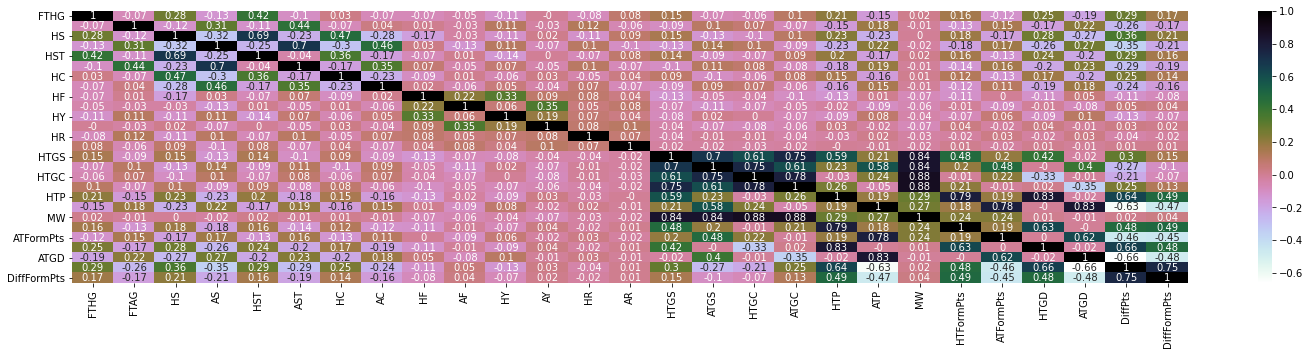

In [32]:
corr = playing_stat.corr().round(2)
plt.figure(figsize = (25,5))
map = heatmap(corr, annot = True, cmap = 'cubehelix_r')
plt.show()

In [33]:
#let's see if we've got missing values in our dataframe
playing_stat.isna().sum()

Date            0
HomeTeam        0
AwayTeam        0
FTHG            0
FTAG            0
FTR             0
HS              0
AS              0
HST             0
AST             0
HC              0
AC              0
HF              0
AF              0
HY              0
AY              0
HR              0
AR              0
HTGS            0
ATGS            0
HTGC            0
ATGC            0
HTP             0
ATP             0
HM1             0
AM1             0
HM2             0
AM2             0
HM3             0
AM3             0
HM4             0
AM4             0
HM5             0
AM5             0
MW              0
HTFormPtsStr    0
ATFormPtsStr    0
HTFormPts       0
ATFormPts       0
HTGD            0
ATGD            0
DiffPts         0
DiffFormPts     0
dtype: int64

In [34]:
playing_stat.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HTGS',
       'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'AM1', 'HM2', 'AM2', 'HM3',
       'AM3', 'HM4', 'AM4', 'HM5', 'AM5', 'MW', 'HTFormPtsStr', 'ATFormPtsStr',
       'HTFormPts', 'ATFormPts', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts'],
      dtype='object')

#Preparing and Training the Logistic Regression model

Firstly, let's use *one-hot encoder* to handle categorical data.

In [35]:
playing_stat.shape

(7600, 43)

In [36]:
playing_stat.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
0,19/08/00,Charlton,Man City,4,0,H,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
2,19/08/00,Coventry,Middlesbrough,1,3,A,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
3,19/08/00,Derby,Southampton,2,2,D,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0
4,19/08/00,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0.0,0.0,0.0,0.0


In [37]:
# this way we make sure we have at least 5 matches played by each team
df = playing_stat[50:]
df.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
50,16/09/00,Aston Villa,Bradford,2,0,H,12,8,7,4,5,6,8,12,0,2,0,0,6,3,5,8,1.333333,0.833333,W,D,W,L,L,D,D,W,D,L,6.0,WWLDD,DLDWL,8,5,0.166667,-0.833333,0.500000,0.500000
51,16/09/00,Charlton,Tottenham,1,0,H,9,10,5,5,7,5,8,10,0,0,0,0,10,8,11,6,0.833333,1.666667,D,W,D,W,L,L,L,D,W,W,6.0,DDLLW,WWLDW,5,10,-0.166667,0.333333,-0.833333,-0.833333
52,16/09/00,Everton,Man United,1,3,A,6,17,4,9,6,5,10,11,4,1,0,0,9,14,8,3,1.166667,1.833333,W,W,L,W,D,D,W,D,L,W,6.0,WLDWL,WWDDW,7,11,0.166667,1.833333,-0.666667,-0.666667
53,16/09/00,Leeds,Ipswich,1,2,A,11,12,6,7,6,3,12,19,1,3,0,0,6,5,5,8,1.166667,0.666667,L,L,D,L,L,W,W,D,W,L,6.0,LDLWW,LLWDL,7,4,0.166667,-0.500000,0.500000,0.500000
54,16/09/00,Southampton,Newcastle,2,0,H,13,10,9,7,4,8,14,14,0,0,0,0,7,7,9,4,0.500000,1.666667,L,D,D,W,D,W,L,W,D,L,6.0,LDDLD,DWWWL,3,10,-0.333333,0.500000,-1.166667,-1.166667


In [38]:
cols = ['HM1',	'AM1',	'HM2',	'AM2',	'HM3',	'AM3',	'HM4',	'AM4',	'HM5',	'AM5', 'FTR']
le = LabelEncoder()

for col in cols:
  df[col] = le.fit_transform(df[col])

df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
50,16/09/00,Aston Villa,Bradford,2,0,2,12,8,7,4,5,6,8,12,0,2,0,0,6,3,5,8,1.333333,0.833333,3,0,3,1,1,0,0,3,0,1,6.0,WWLDD,DLDWL,8,5,0.166667,-0.833333,0.500000,0.500000
51,16/09/00,Charlton,Tottenham,1,0,2,9,10,5,5,7,5,8,10,0,0,0,0,10,8,11,6,0.833333,1.666667,0,3,0,3,1,1,1,0,3,3,6.0,DDLLW,WWLDW,5,10,-0.166667,0.333333,-0.833333,-0.833333
52,16/09/00,Everton,Man United,1,3,0,6,17,4,9,6,5,10,11,4,1,0,0,9,14,8,3,1.166667,1.833333,3,3,1,3,0,0,3,0,1,3,6.0,WLDWL,WWDDW,7,11,0.166667,1.833333,-0.666667,-0.666667
53,16/09/00,Leeds,Ipswich,1,2,0,11,12,6,7,6,3,12,19,1,3,0,0,6,5,5,8,1.166667,0.666667,1,1,0,1,1,3,3,0,3,1,6.0,LDLWW,LLWDL,7,4,0.166667,-0.500000,0.500000,0.500000
54,16/09/00,Southampton,Newcastle,2,0,2,13,10,9,7,4,8,14,14,0,0,0,0,7,7,9,4,0.500000,1.666667,1,0,0,3,0,3,1,3,0,1,6.0,LDDLD,DWWWL,3,10,-0.333333,0.500000,-1.166667,-1.166667


In [39]:
scaler = StandardScaler()
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = ['HTGD','ATGD','HTP','ATP', 'DiffPts', 'DiffFormPts']

for col in cols:
    df[col] = scale(df[col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [40]:
# mean is 0 and variance is 1.
print('média: ', round(np.mean(df['HTP']), 1), '\nvariância: ', round(np.var(df['HTP']), 1))

média:  0.0 
variância:  1.0


In [41]:
#z = df.loc[df['Date'] == '13/08/16']
#z = df.copy()
#z[6030:]
#z.in

In [42]:
df[:6030]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts
50,16/09/00,Aston Villa,Bradford,2,0,2,12,8,7,4,5,6,8,12,0,2,0,0,6,3,5,8,0.222488,-0.750107,3,0,3,1,1,0,0,3,0,1,6.0,WWLDD,DLDWL,8,5,0.247433,-1.194069,0.759452,1.263048
51,16/09/00,Charlton,Tottenham,1,0,2,9,10,5,5,7,5,8,10,0,0,0,0,10,8,11,6,-0.712436,0.824349,0,3,0,3,1,1,1,0,3,3,6.0,DDLLW,WWLDW,5,10,-0.222035,0.451805,-1.202931,-1.998969
52,16/09/00,Everton,Man United,1,3,0,6,17,4,9,6,5,10,11,4,1,0,0,9,14,8,3,-0.089153,1.139240,3,3,1,3,0,0,3,0,1,3,6.0,WLDWL,WWDDW,7,11,0.247433,2.567928,-0.957633,-1.591217
53,16/09/00,Leeds,Ipswich,1,2,0,11,12,6,7,6,3,12,19,1,3,0,0,6,5,5,8,-0.089153,-1.064998,1,1,0,1,1,3,3,0,3,1,6.0,LDLWW,LLWDL,7,4,0.247433,-0.723819,0.759452,1.263048
54,16/09/00,Southampton,Newcastle,2,0,2,13,10,9,7,4,8,14,14,0,0,0,0,7,7,9,4,-1.335718,0.824349,1,0,0,3,0,3,1,3,0,1,6.0,LDDLD,DWWWL,3,10,-0.456769,0.686929,-1.693527,-2.814473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,15/05/2016,Stoke,West Ham,2,1,2,7,20,4,7,4,10,8,12,3,1,0,0,39,64,54,49,0.091271,0.758056,1,3,0,1,1,3,1,3,1,0,38.0,LDLLL,WLWWD,1,10,-0.543250,0.538429,-0.518679,-0.539646
6076,15/05/2016,Swansea,Man City,1,1,1,4,18,1,5,4,4,4,19,1,3,0,0,41,70,51,40,-0.007142,0.907215,3,0,3,1,1,3,1,0,3,3,38.0,WWLLW,DLWDW,9,8,-0.357933,1.095304,-0.712336,0.104173
6077,15/05/2016,Watford,Sunderland,2,2,1,21,6,6,4,7,4,11,10,1,0,0,0,38,46,48,60,-0.105555,-0.435216,1,3,1,3,3,0,1,0,3,3,38.0,LLWLW,WWDDW,6,11,-0.357933,-0.538195,0.255945,-0.282118
6078,15/05/2016,West Brom,Liverpool,1,1,1,13,7,1,3,7,5,11,14,3,1,0,0,33,62,47,49,-0.203968,0.608897,0,0,1,3,0,1,1,0,1,3,38.0,DLDLL,DWLDW,2,8,-0.506186,0.464179,-0.634873,-0.346500


In [43]:
# getting from season 2016/2017 for testing and before this season for training
x = df[6030:]

x_train = df[:6030]
x_test = x

y_train = x_train['FTR'] 
y_test = x_test['FTR']

x_train = df[:6030].drop(columns = ['HTFormPtsStr',	'ATFormPtsStr', 'Date',	'HomeTeam',	'AwayTeam', 'FTR', 'FTHG',	'FTAG', 'MW'])
x_test = x.drop(columns = ['HTFormPtsStr',	'ATFormPtsStr', 'Date',	'HomeTeam',	'AwayTeam', 'FTR', 'FTHG',	'FTAG', 'MW'])

In [44]:
print(
    ' x_train: ', x_train.shape, '\n',
    'x_test: ', x_test.shape, '\n',
    'y_train: ', y_train.shape,'\n',
    'y_test: ', y_test.shape)

 x_train:  (6030, 34) 
 x_test:  (1520, 34) 
 y_train:  (6030,) 
 y_test:  (1520,)


##Not penalizing the model

In [45]:
# log_reg_no = LogisticRegression(random_state = 42, multi_class='multinomial', solver='saga').fit(x_train, y_train)
# log_reg_coefs = log_reg_no.coef_[0]
# log_reg_coefs

log_reg_no = LogisticRegression(random_state = 42, solver='newton-cg').fit(x_train, y_train)
log_reg_coefs = log_reg_no.coef_[0]
log_reg_coefs

array([ 0.04653929, -0.03508597, -0.15450836,  0.19441401,  0.05033271,
       -0.07663756, -0.01284454,  0.0050854 ,  0.08442453, -0.07557663,
        0.67492505, -0.46573085, -0.00523846,  0.00192633,  0.00460341,
       -0.00392681, -0.10239971,  0.0829035 , -0.00512276,  0.13105824,
        0.03399572, -0.04519316,  0.02747921, -0.00966831,  0.03448   ,
       -0.01126664,  0.05719195, -0.02000904, -0.05254483,  0.04596293,
       -0.07888958,  0.09531984, -0.14518167,  0.22957502])

In [46]:
# test error not penalizing the model
y_pred_no = log_reg_no.predict_proba(x_test)
log_loss(y_test, y_pred_no) 

0.8561040785618572

In [47]:
# accuracy on train
y_pred_treino = log_reg_no.predict(x_train)
accuracy_score(y_train, y_pred_treino)

0.5888888888888889

In [48]:
# accuracy on test
y_pred_test = log_reg_no.predict(x_test)
accuracy_score(y_test, y_pred_test)

0.6065789473684211

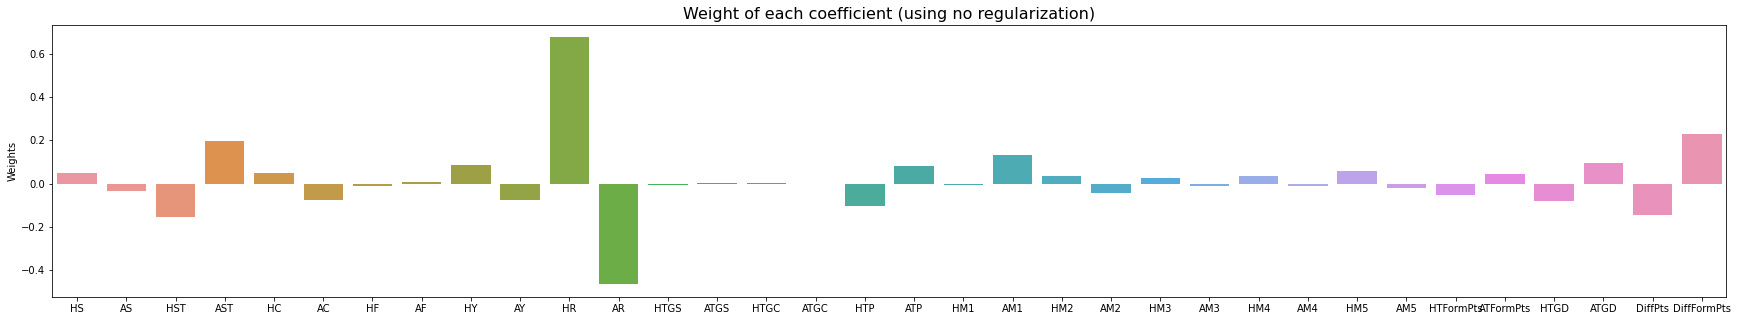

In [49]:
plt.figure(figsize = (30, 5))
sns.barplot(x = x_train.columns, y = log_reg_coefs)
plt.title("Weight of each coefficient (using no regularization)", fontdict = {'size': 16})
plt.ylabel("Weights")
plt.show()

##Penalizing the model

###Finding the best hyperparameter

In [50]:
#log_reg = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state = 42)
#hyp_param = dict(C = np.linspace(10**-5, 10, 100), penalty = ['l2'])

log_reg = LogisticRegression(solver='liblinear', random_state = 42)
hyp_param = dict(C = np.linspace(10**-5, 10, 100), penalty = ['l1'])

# training the model
rscv = RandomizedSearchCV(log_reg, hyp_param, cv = 3)
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C...
       8.08081e+00, 8.18182e+00, 8.28283e+00, 8.38384e+00, 8.48485e+00,
       8.58586e+00, 8.68687e+00, 8.78788e+00, 8.88889e+00, 8.98990e+00,
       9.09091e+00, 9.19192e+00, 9.29293e+00, 9.39394e+00, 9.49495e+00,
       9.59596e+0

In [51]:
#best C and regularization
C = rscv.best_params_
c = C['C']
penalty = C['penalty']

#printing c (best hyperparameter) and penalty
print("C: ", c, "\nPenalty: ", penalty)

C:  9.49495 
Penalty:  l1


###Training and Predicting using the best hyperparameter found above

In [52]:
pipe = Pipeline([('log_reg', LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear'))])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('log_reg',
                 LogisticRegression(C=9.49495, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [53]:
# coefficients of our logistic regression model (notice that some were pushed to zero)
log_reg_coefs = pipe['log_reg'].coef_[0]
log_reg_coefs

array([ 0.07033464, -0.05404168, -0.24053393,  0.29548152,  0.07839165,
       -0.11569136, -0.01942689,  0.00850877,  0.12830032, -0.11285206,
        0.98835   , -0.72816424, -0.00846313,  0.00293817,  0.00700478,
       -0.00559568, -0.06440946,  0.02803974, -0.01881997,  0.19458169,
        0.05214744, -0.07017404,  0.04234997, -0.01726074,  0.05249185,
       -0.01805966,  0.08356879, -0.03217911, -0.07901639,  0.07075902,
       -0.12497141,  0.1483579 , -0.34405145,  0.34698006])

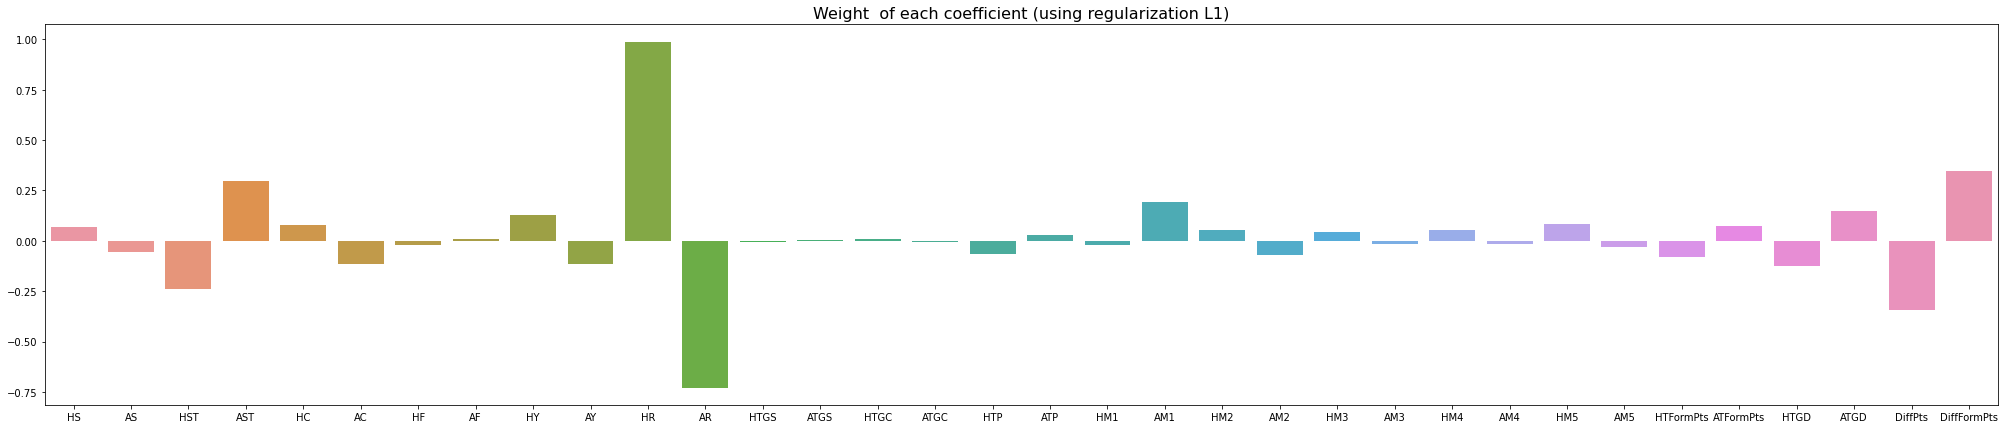

In [54]:
plt.figure(figsize = (35, 7))
sns.barplot(x = x_train.columns, y = log_reg_coefs)
plt.title("Weight  of each coefficient (using regularization L1)", fontdict = {'size': 16})
plt.show()

In [55]:
y_pred = pipe.predict(x_test)

#predicted values from test
y_pred

array([0, 2, 2, ..., 0, 0, 2])

In [56]:
y_proba = pipe.predict_proba(x_test)
y_proba_train = pipe.predict_proba(x_train)
y_proba[:, 1]

array([0.25496207, 0.2708978 , 0.20429012, ..., 0.23224505, 0.22326973,
       0.31999247])

In [57]:
# train error
print("Train error: ", log_loss(y_train, y_proba_train))

Train error:  0.895636461752011


In [58]:
# test error
print("Test error: ", log_loss(y_test, y_proba))

Test error:  0.8629673941053422


##Evaluating our results

To evaluate our model, let's use a confusion matrix and get important metrics from it.

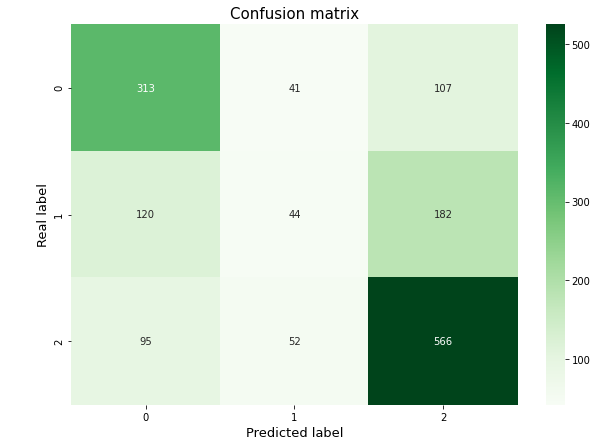

In [59]:
# Confusion matrix
plt.figure(figsize = (10, 7))
c_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1, 2])
sns.heatmap(c_matrix, annot = True, cmap =  'Greens', robust = True, fmt = '.3g')
plt.title("Confusion matrix", size = 15)
plt.ylabel("\n\nReal label", size = 13)
plt.xlabel("Predicted label", size = 13)
plt.show()


In [60]:
print('Confusion matrix: \n', c_matrix)

Confusion matrix: 
 [[313  41 107]
 [120  44 182]
 [ 95  52 566]]


In [61]:
print('Accuracy on test: ', accuracy_score(y_test, y_pred))

Accuracy on test:  0.6072368421052632


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       461
           1       0.32      0.13      0.18       346
           2       0.66      0.79      0.72       713

    accuracy                           0.61      1520
   macro avg       0.53      0.53      0.51      1520
weighted avg       0.56      0.61      0.57      1520

